In [ ]:
import tensorflow as tf
device_list = tf.test.gpu_device_name()
device_list

if device_list != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_list))

Found GPU at: /device:GPU:0


## Reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/aayush210789/Deception-Detection-on-Amazon-reviews-dataset/blob/master/amazon_reviews.txt

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import re

# Importing sklearn.metrics libraries
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Libraries required for hyper-parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MS-Thesis backup/datasets/amazon_reviews.txt", delimiter = "\t")

In [ ]:
data.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [ ]:
data.shape

(21000, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DOC_ID             21000 non-null  int64 
 1   LABEL              21000 non-null  object
 2   RATING             21000 non-null  int64 
 3   VERIFIED_PURCHASE  21000 non-null  object
 4   PRODUCT_CATEGORY   21000 non-null  object
 5   PRODUCT_ID         21000 non-null  object
 6   PRODUCT_TITLE      21000 non-null  object
 7   REVIEW_TITLE       21000 non-null  object
 8   REVIEW_TEXT        21000 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


## Data Cleaning

In [ ]:
#Dropping unnecessary columns
data.drop(['DOC_ID','PRODUCT_ID'], axis=1, inplace=True) #The IDs in this case do not provide any useful information, hence dropping them

In [ ]:
data.LABEL.value_counts()

__label1__    10500
__label2__    10500
Name: LABEL, dtype: int64

In [ ]:
# Renaming the Label into numeric
data.loc[data["LABEL"] == "__label1__", "LABEL"] = '1'
data.loc[data["LABEL"] == "__label2__", "LABEL"] = '0'

In [ ]:
data.head(1)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,4,N,PC,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL              21000 non-null  object
 1   RATING             21000 non-null  int64 
 2   VERIFIED_PURCHASE  21000 non-null  object
 3   PRODUCT_CATEGORY   21000 non-null  object
 4   PRODUCT_TITLE      21000 non-null  object
 5   REVIEW_TITLE       21000 non-null  object
 6   REVIEW_TEXT        21000 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [ ]:
data['LABEL'] = data['LABEL'].astype(int)

## EDA

##### Univariate Analysis

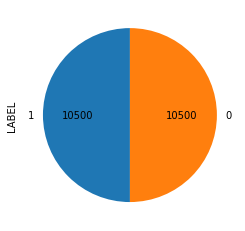

In [ ]:
values=data['LABEL'].value_counts()
data.LABEL.value_counts().plot(kind='pie', startangle = 90,autopct= lambda x: '{:.0f}'.format(x*values.sum()/100));

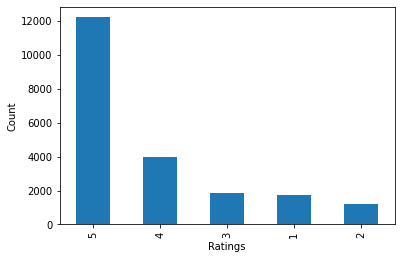

In [ ]:
data.RATING.value_counts().plot(kind='bar')
plt.xlabel('Ratings')
plt.ylabel('Count');

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

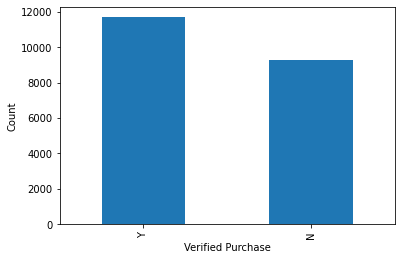

In [ ]:
data['VERIFIED_PURCHASE'].value_counts().plot(kind='bar',)
plt.xlabel('Verified Purchase')
plt.ylabel('Count');

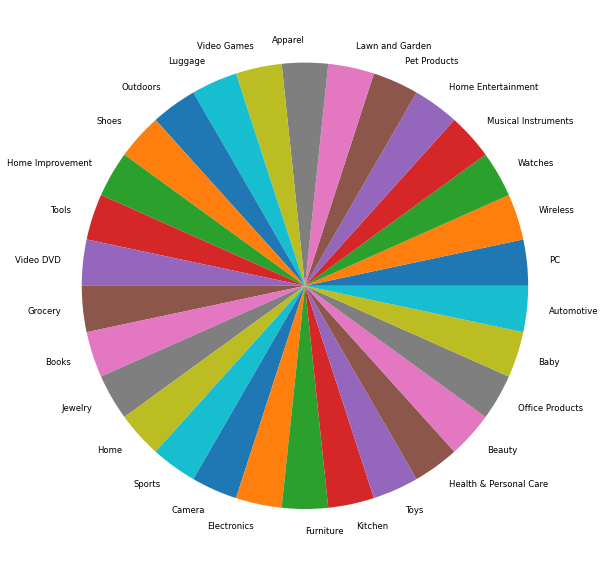

In [ ]:
plt.figure(figsize=(10,15))
data.PRODUCT_CATEGORY.value_counts().plot(kind = 'pie', fontsize = 8.5)
plt.ylabel(' ');

##### Inference
All the categories have equal number of reviews

#### Bi-variate analysis

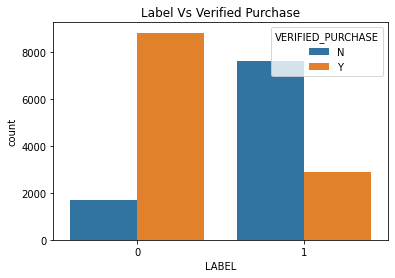

In [ ]:
sns.countplot(x='LABEL', hue='VERIFIED_PURCHASE', data=data)
plt.title('Label Vs Verified Purchase');

##### Inference:
Most fake reviews are from customers who have not purchased the product on the website

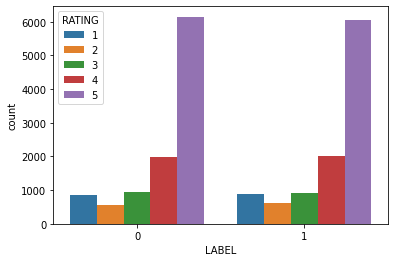

In [ ]:
sns.countplot(x='LABEL', hue='RATING', data=data);

##### Inference:
- Ratings are divided equally for both the labels
- Both fake and real reviews have high/positive ratings

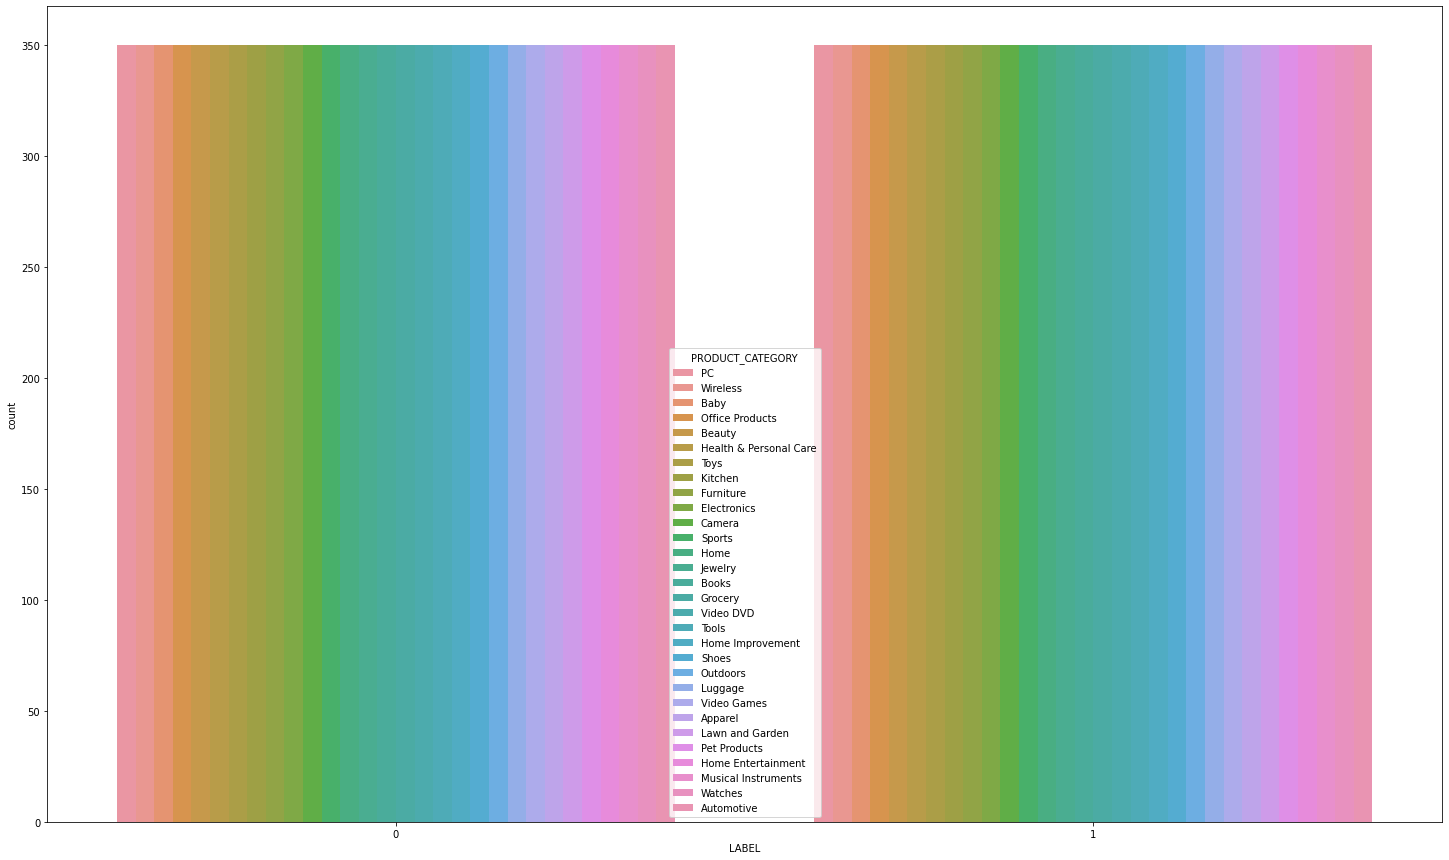

In [ ]:
plt.figure(figsize=(25,15))
sns.countplot(x='LABEL', hue='PRODUCT_CATEGORY', data=data);

##### Inference
Equal number of product reviews for both the labels

## Analysis

#####  1. Visualising the sentiment of both fake and real reviews using TextBlob

In [ ]:
from textblob import TextBlob
data['sentiment_score'] = data['REVIEW_TEXT'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
def label_column(x):
    if x == 0:
        return 'Neutral'
    elif x < 0:
        return 'Negative'
    else:
        return 'Positive'

In [ ]:
data['sentiment_label']=data['sentiment_score'].apply(lambda x:label_column(x))
data.head()

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,sentiment_score,sentiment_label
0,1,4,N,PC,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",-0.300000,Negative
1,1,4,Y,Wireless,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,0.219226,Positive
2,1,3,N,Baby,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,0.347143,Positive
3,1,4,N,Office Products,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,-0.088542,Negative
4,1,4,N,Beauty,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,0.145833,Positive


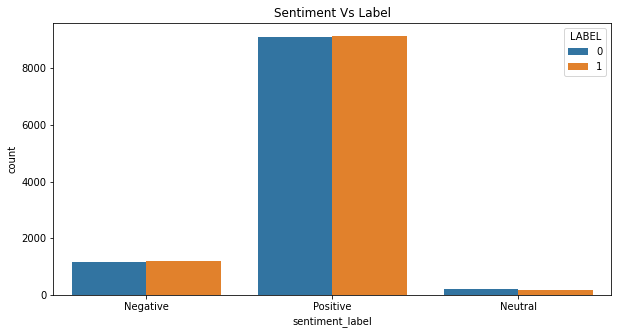

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='LABEL', data=data)
plt.title('Sentiment Vs Label');

##### Inference:
Most fake reviews have higher positive and negative sentiment indicating the reviewers either wrote very good things about a product or gave negative feedbacks

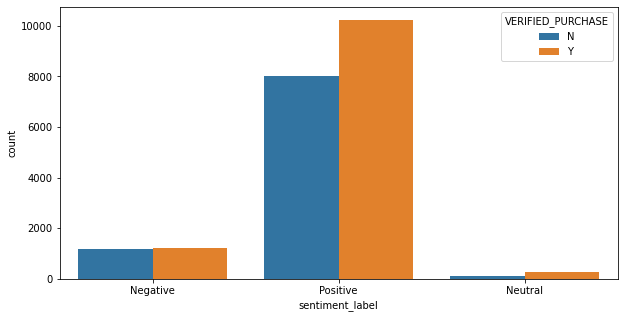

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='VERIFIED_PURCHASE', data=data);

##### Inference:
Customers who have purchased the product have mostly have positive sentiment score

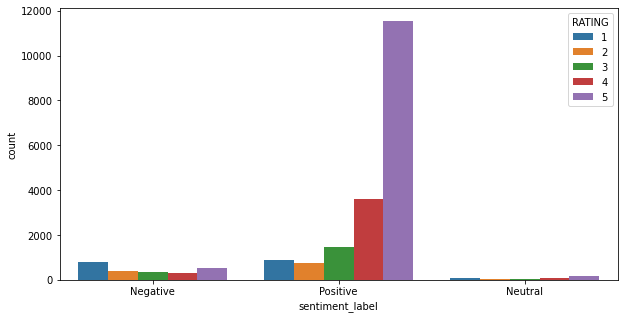

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='RATING', data=data);

##### Inference
Positive sentiment has highest rating as 5

#####  Checking the length of the reviews
- longer/shorter reviews have been verified?

In [ ]:
data['review_length'] = data['REVIEW_TEXT'].map(len)

In [ ]:
max(data['review_length'])

16188

In [ ]:
min(data['review_length'])

98

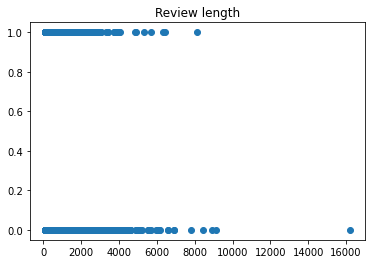

In [ ]:
plt.scatter(x = 'review_length', y = 'LABEL', data=data)
plt.title('Review length');

##### Inference
All fake reviews have length less than 8k words

In [ ]:
length = data.groupby('LABEL')['review_length'].mean()
length.head()

LABEL
0    428.064571
1    316.538857
Name: review_length, dtype: float64

##### Inference:
Fake reviews are shorter in length

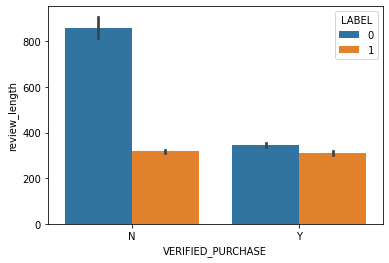

In [ ]:
ax = sns.barplot(x="VERIFIED_PURCHASE", y="review_length", hue="LABEL", data=data)

##### Inference:
- Fake reviews are shorter in length in both cases in regardless of product being purchased or not
- Real reviews which have not been verified has the highest review length

##### Inference:
Fake reviews with neutral tone have higher review length.
Real reviews have highest positive and negative sentiment


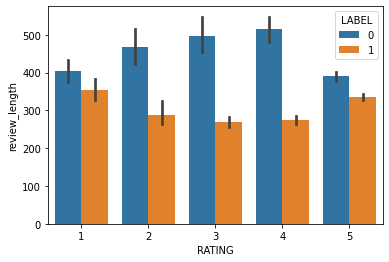

In [ ]:
ax = sns.barplot(x="RATING", y="review_length", hue="LABEL", data=data)

## DISTILBERT - Version 3 - WORKING MODEL

In [ ]:
#!pip uninstall tensorflow -y
#!pip install tensorflow==2.8

In [ ]:
#!pip install keras
#!pip install tensorflow

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.8 MB/s 
     |████████████████████████████████| 120 kB 64.5 MB/s 
     |████████████████████████████████| 6.6 MB 45.7 MB/s 


In [ ]:
# converting features into appripriate format in order to feed to the model
data['VERIFIED_PURCHASE'].replace('Y','YES', inplace=True)
data['VERIFIED_PURCHASE'].replace('N','NO',inplace=True)

def rating(x):
    if x == 5:
        return 'Very Good'
    elif x == 4:
        return 'Good'
    elif x == 3:
        return 'Avg'
    elif x == 2:
        return 'Poor'
    else:
        return 'Bad'

data['RATING'] = data['RATING'].apply(lambda x:rating(x))

data['combined'] = data['REVIEW_TEXT'] + ' ' + data['RATING'] + ' ' + data['VERIFIED_PURCHASE'] + ' ' + data['PRODUCT_CATEGORY']

In [ ]:
## Train and test split 
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(data, test_size=0.3, shuffle=True, stratify=None, random_state=42)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [ ]:
train_dataset.shape

(14700, 11)

In [ ]:
train_dataset.LABEL.value_counts()

0    7389
1    7311
Name: LABEL, dtype: int64

In [ ]:
test_dataset.LABEL.value_counts()

1    3189
0    3111
Name: LABEL, dtype: int64

In [ ]:
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig

In [ ]:
from tqdm import tqdm

In [ ]:
train_dataset.head(2)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,sentiment_score,sentiment_label,review_length,combined
0,0,Good,YES,Lawn and Garden,Grace Alley Nylon American Flag with Embroider...,Good flag at descent price,"The flag arrived on time,, and appears to be g...",0.700000,Positive,107,"The flag arrived on time,, and appears to be g..."
1,0,Avg,YES,PC,ASUS VivoPC VM62N-G039R (Discontinued by Manuf...,1 is horrible as usual,Bought this to become my new media center PC. ...,-0.028864,Negative,357,Bought this to become my new media center PC. ...


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_dataset['LABEL'] = le.fit_transform(train_dataset['LABEL'])

In [ ]:
train_dataset.LABEL.value_counts()

0    7389
1    7311
Name: LABEL, dtype: int64

In [ ]:
X1 = train_dataset['combined']
y = train_dataset['LABEL']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X1,y, test_size=0.3, shuffle=True, stratify=None, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((10290,), (10290,))

In [ ]:
X_val.shape, y_val.shape

((4410,), (4410,))

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name) # Loading the tokenizer

In [ ]:
max_val = 0
for sent in (X_train.tolist() + X_train.tolist() + X_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 3701


In [ ]:
MAX_LENGTH = 512

tokenizer = DistilBertTokenizer.from_pretrained(model_name,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [ ]:
X_train_token = tokenize(X_train, tokenizer)
X_val_token = tokenize(X_val, tokenizer)

100%|██████████| 4410/4410 [00:11<00:00, 397.12it/s]


In [ ]:
index_num = 10

print(train_dataset.loc[index_num]['LABEL'], '\n')

print(X_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(X_train[index_num])
temp_ids = tokenizer.encode(X_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

0 

These are pretty standard lights...they work...they haven't spontaneously exploded or anything. I purchased them to turn into flower lights (they haven't caught on fire either which is also a plus) and they've been affixed to my wall for the past two years. They still work, but I don't turn them on all that often. Very Good YES Lawn and Garden 

ID's	Input Tokens
101	[CLS]
2122	these
2024	are
3492	pretty
3115	standard
4597	lights
1012	.
1012	.
1012	.
2027	they
2147	work
1012	.
1012	.
1012	.
2027	they
4033	haven
1005	'
1056	t
27491	spontaneously
9913	exploded
2030	or
2505	anything
1012	.
1045	i
4156	purchased
2068	them
2000	to
2735	turn
2046	into
6546	flower
4597	lights
1006	(
2027	they
4033	haven
1005	'
1056	t
3236	caught
2006	on
2543	fire
2593	either
2029	which
2003	is
2036	also
1037	a
4606	plus
1007	)
1998	and
2027	they
1005	'
2310	ve
2042	been
21358	af
23901	##fixed
2000	to
2026	my
2813	wall
2005	for
1996	the
2627	past
2048	two
2086	years
1012	.
2027	they
2145	still
2147	work
10

In [ ]:
### Model creation
config = DistilBertConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(model_name, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X) ###
X = tf.keras.layers.Dense(2, activation='sigmoid')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 512, 768),                                                   
                                 hidden_states=((No                                           

In [ ]:
### Create an output directory
import os
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [ ]:
#print(X_train_token.shape)
print(y_train.shape)
#print(X_test_token.shape)
print(y_val.shape)

(10290,)
(4410,)


In [ ]:
y_train

567      0
7053     1
4785     1
2245     0
4165     0
        ..
5191     1
13418    1
5390     1
860      1
7270     1
Name: LABEL, Length: 10290, dtype: int64

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(np.asarray(y_train))
y_val = to_categorical(np.asarray(y_val))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_token, 
                    y_train, 
                    epochs = 15,
                    batch_size=32, 
                    validation_data=(X_val_token, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/15
322/322 [==============================] - 265s 783ms/step - loss: 0.5077 - accuracy: 0.7635 - val_loss: 0.4414 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/15
322/322 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.8119
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
322/322 [==============================] - 249s 775ms/step - loss: 0.4331 - accuracy: 0.8119 - val_loss: 0.4491 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 3/15
322/322 [==============================] - 249s 775ms/step - loss: 0.3923 - accuracy: 0.8322 - val_loss: 0.4251 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 4/15
322/322 [==============================] - 249s 774ms/step - loss: 0.3789 - accuracy: 0.8382 - val_loss: 0.4134 - val_accuracy: 0.8286 - lr: 1.0000e-04
Epoch 5/15
322/322 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8459
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
322/322 [============

Lowest Validation Loss: epoch 4
Highest Validation Accuracy: epoch 4


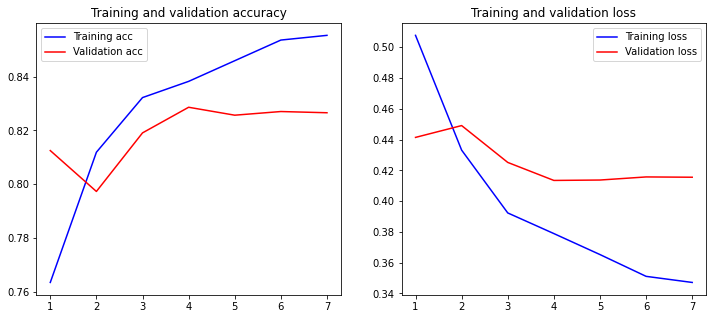

In [ ]:
#plotting the training Accuracy and Loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

In [ ]:
def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [ ]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

In [ ]:
test_dataset.head(1)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,sentiment_score,sentiment_label,review_length,combined
0,1,Avg,NO,Shoes,Sunbelt Men's Neptune 190 Polarized Sunglasses...,Happy with my purchase,Just received my pair of sunglasses in the mai...,0.628333,Positive,199,Just received my pair of sunglasses in the mai...


In [ ]:
X_test = test_dataset['combined']

In [ ]:
test_dataset['LABEL'] = le.transform(test_dataset['LABEL'])

In [ ]:
y_test = test_dataset['LABEL']

In [ ]:
y_test.value_counts()

1    3189
0    3111
Name: LABEL, dtype: int64

In [ ]:
X_test_token = tokenize(X_test, tokenizer)

100%|██████████| 6300/6300 [00:14<00:00, 426.67it/s]


In [ ]:
y_test = to_categorical(np.asarray(y_test))

In [ ]:
model.evaluate(X_test_token, y_test)

197/197 [==============================] - 83s 422ms/step - loss: 0.4241 - accuracy: 0.8235


[0.42414581775665283, 0.8234920501708984]

In [ ]:
pred = model.predict(X_test_token)

In [ ]:
print("ROC-AUC Score", roc_auc_score(y_test,np.round(abs(pred))))
print("Classification Report:\n", classification_report(y_test, np.round(abs(pred)), target_names = ["real", "fake"]))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test.argmax(axis=1), y_pred = pred.argmax(axis=1)))
print("DistilBert Accuracy: ",accuracy_score(y_test,  np.round(abs(pred))))

ROC-AUC Score 0.823236396327419
Classification Report:
               precision    recall  f1-score   support

        real       0.81      0.84      0.82      3111
        fake       0.84      0.80      0.82      3189

   micro avg       0.82      0.82      0.82      6300
   macro avg       0.82      0.82      0.82      6300
weighted avg       0.82      0.82      0.82      6300
 samples avg       0.82      0.82      0.82      6300

Confusion matrix:
 [[2618  493]
 [ 619 2570]]
DistilBert Accuracy:  0.8207936507936507
